In [1]:
NAME = "Matthew Shaw, Gopikrishnan Nair, Seung Jae Lieu"
GROUP = "Group 6"

# Setup

In [2]:
import sys
print(sys.version)
py_ver = sys.version.split()[0]
print(f"\n** You appear to be running Python version {py_ver} **")

3.9.6 (default, Jul 30 2021, 11:42:22) [MSC v.1916 64 bit (AMD64)]

** You appear to be running Python version 3.9.6 **


In [3]:
# Imports
from node import Node
from link import Link
from path import Path
from od import OD
from network import Network
import pickle
from nose.tools import assert_almost_equal
import random
import numpy as np

import sys
import traceback
import utils
import copy

FRANK_WOLFE_STEPSIZE_PRECISION = 1e-7
UE_PRECISION = 10

# Additional Imports, Packages included
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import timeit

# Additional Imports, Packages not included, environment must be updated
import pandas as pd
import networkx as nx

In [4]:
# Network Import
net = Network("SiouxFalls_net.tntp", "SiouxFalls_trips.tntp")

# Set speed limits for 40mph on all links
for ij in net.link:
    net.link[ij].speedLimit = 40

# Implementation

The implementation of a Multi-class network involves building off the original STA implementation with several changes made at various stages. The changes made to extend the single class network to a Multi-class Network (HDV and EVs) are as detailed below:

1. **Separate Global functions** were created for calculating the costs.  
The default BPR link cost function was modified to reflect the new parameters $\lambda$ (for additional energy consumption) and $K_e$ (for energy consumption reduction in EVs).

2. The corresponding **Levin Boyle's equations** were used to calculate the capacities for the links (both HDVs and EVs). 

3. **Implementing Diagonalization for Multi-Class Networks:**  
The Frank Wolfe Step Size is then calculated by making use of costs which are a function of parameters of both the layers. These costs are calculated based on the current states of both the HDV and the EV layerand then updated in the original layers i.e., separately in the HDV and the EV layer.  
The step size is then iteratively found by moving the current flows towards the target flows using the combined costs. The derivative is a function of both layers and their target flows.

4. **Implementing Multi-Class Frank Wolfe Algorithm:**  
It is analogous to a Single Class implementation with the only difference being that every sub-function in the code takes an input of two networks and their characteristics. Only the initial All-or-nothing assignments are done separately for HDVs and EVs.  
The convergence criteria are also a function of the travel times of both layers (their costs), and the convergence is checked in the usual way with a target gap.

5. **Implementing Dummy Nodes for changing in network characteristics (Charging Lane):**  
For the purposes of changing a link within the network (link 10-15), a separate function is created which will create a new link and a new node. This is intended to split the original link into two links connecting a dummy node.  
This function is called later twice, once each for the HDV layer and the EV layer. So each time a new link is created it has the different corresponding parameters of both HDVs and EVs.  
Once the layers are updated after creating these new links, it is equivalent to a single network having a link of two differently behaving lanes.

### Global Functions (Used in All Scenarios)

In [5]:
# Calculate freeFlowTime on link, in mins
def set_freeFlowTime(network):
    for ij in network.link:
        network.link[ij].freeFlowTime = network.link[ij].length / network.link[ij].speedLimit
        
# Set free flow time on all links in network
set_freeFlowTime(net)

In [6]:
# Calculate travel time on link, in mins, using the modified BPR function with traffic oscillation
def calculateCost_OSC(link, K_e = 1.0, lambd = 0.1):
    """
    Calculates the cost of the link using a modified BPR function including a parameter for traffic oscillation.
    This cost is returned by the method and NOT stored in the cost attribute.
    """
    vcRatio = link.flow / link.capacity
    # Protect against negative flows, 0^0 errors.
    if vcRatio <= 0:
        return link.freeFlowTime
    travelCost = link.freeFlowTime * (1 + (vcRatio)**4) + K_e * lambd * vcRatio
    return travelCost

# Bind this function to the link class to replace the original calculateCost function
setattr(Link, "calculateCost", calculateCost_OSC)

In [7]:
# Calculate link capacity across the network according to Levin-Boyles
def set_link_capacity(linkOG, delta_t, l, N = 2):
    linkOG.capacity = N * linkOG.speedLimit * (1 / (linkOG.speedLimit * delta_t * (1/3600) + l * (1/1609)))

def set_network_capacity(network, delta_t, l, N = 2):
    for ij, link_ij in network.link.items():
        set_link_capacity(link_ij, delta_t, l, N)

In [8]:
# Update the UE FW method to include an output log
def userEquilibriumFW(self,
                    maxIterations = 100,
                    targetGap = 1e-4):
    """
    This method uses the (link-based) convex combinations algorithm to solve
    for user equilibrium.  Arguments are the following:
        maxIterations -- stop after this many iterations have been performed
        targetGap     -- stop once the gap is below this level
    """
    initialFlows = self.allOrNothing()
    for ij in self.link:
        self.link[ij].flow = initialFlows[ij]
        self.link[ij].updateCost()

    # Output log
    df_log = []
    
    iteration = 0
    while iteration < maxIterations:
        iteration += 1

        targetFlows = self.allOrNothing()

        stepSize = self.FrankWolfeStepSize(targetFlows)
        self.shiftFlows(targetFlows, stepSize)

        for ij in self.link:
            self.link[ij].updateCost()

        ### convergence criterion 
        SPTT = 0
        TSTT = 0
        for ij in self.link:
            SPTT += self.link[ij].cost * self.allOrNothing()[ij]
            TSTT += self.link[ij].cost * self.link[ij].flow
        currentGap = TSTT/SPTT-1
        print("Iteration %d: gap %f; Total System Travel Cost %f" % (iteration, currentGap, TSTT))
        # Update log
        df_log.append(pd.DataFrame([[iteration,currentGap,TSTT]],columns = ['iteration','currentGap','TSTC']))
                      
        if currentGap < targetGap:
            break
    
    # Return complete log
    return pd.concat(df_log).reset_index(drop=True)

# Bind this function to the link class to replace the original userEquilibriumFW function
setattr(Network, "userEquilibriumFW", userEquilibriumFW)

### Multiclass Functions (Used in Scenarios 2+)

In [9]:
# Calculate Link Costs as a joint function of two networks, one HEV and one EV
def calculate_costs(network_HDV, network_EV, K_e = 0.4, lambd = 0.1):
    # Checks that both networks have identical incidence matrices, defines list of links
    assert network_HDV.link.keys() == network_EV.link.keys()
    assert network_HDV.formIncidenceMatrix() == network_EV.formIncidenceMatrix()
    linklist = network_HDV.link.keys()
    
    for ij in linklist:
        if network_HDV.link[ij].capacity <= 0.0001:
            HDV_VCRatio = 0
        else:
            HDV_VCRatio = network_HDV.link[ij].flow / network_HDV.link[ij].capacity
        if network_EV.link[ij].capacity  <= 0.0001:
            EV_VCRatio = 0
        else:
            EV_VCRatio = network_EV.link[ij].flow  / network_EV.link[ij].capacity
        VCRatio = (HDV_VCRatio + EV_VCRatio)
        
        # Divide by zero protection
        if VCRatio <= 0:
            network_HDV.link[ij].cost = network_HDV.link[ij].freeFlowTime
            network_EV.link[ij].cost  = network_EV.link[ij].freeFlowTime
            
        # Link cost calculation according to the formula, joint function of HDV and EV network
        else:
            network_HDV.link[ij].cost = ( network_HDV.link[ij].freeFlowTime * (1 + (VCRatio)**4) 
                                         + lambd * VCRatio )
            network_EV.link[ij].cost  = ( network_EV.link[ij].freeFlowTime  * (1 + (VCRatio)**4) 
                                         + K_e * lambd * VCRatio )
        if network_HDV.link[ij].capacity <= 0.0001:
            network_HDV.link[ij].cost = 99999 
        if network_EV.link[ij].capacity <= 0.0001:
            network_EV.link[ij].cost  = 99999 

In [10]:
# Calculate Franke-Wolfe step size as a joint function of two networks and their respective targets
# Employs diagonalization: flows are only stepped towards corresponding target for each network
def MultiClassFWSS(net1, net2, target1, target2, precision = FRANK_WOLFE_STEPSIZE_PRECISION):
    """
    This method returns the step size alpha used by the Frank-Wolfe algorithm using diagonalization.

    The current link flows are given in the netX.link[ij].flow attributes, and the
    target flows are given in the targetX dictionary.

    The precision argument dictates how close your method needs to come to finding
    the exact Frank-Wolfe step size: you are fine if the absolute difference
    between the optimal step size, and the value returned by your method, is less than
    precision.
    """
    # Checks that both networks have identical incidence matrices, defines list of links
    assert net1.link.keys() == net2.link.keys() == target1.keys() == target2.keys()
    assert net1.formIncidenceMatrix() == net2.formIncidenceMatrix()
    linklist = net1.link.keys()
    
    # Backup current flows
    currentFlows1 = {ij: net1.link[ij].flow for ij in net1.link}
    currentFlows2 = {ij: net2.link[ij].flow for ij in net2.link}

    low = 0
    high = 1
    while (high-low) > precision:
        alpha = (low + high)/2
        derivative = 0
        for ij in linklist:
            # Diagonalization for each network           
            net1.link[ij].flow = alpha*target1[ij] + (1-alpha)*currentFlows1[ij]
            net2.link[ij].flow = alpha*target2[ij] + (1-alpha)*currentFlows2[ij]
            
        # Calculating costs as a joint function of two network states (HDV, EV)
        calculate_costs(network_HDV = net1, network_EV = net2)
            
        for ij in linklist:
            # Derivative as a function of both network states and their respective targets
            derivative += (target1[ij] - currentFlows1[ij])*net1.link[ij].cost
            derivative += (target2[ij] - currentFlows2[ij])*net2.link[ij].cost

        if derivative < 0:
            low = alpha
        else:
            high = alpha

    ### restore the current link flows
    for ij in linklist:
        net1.link[ij].flow = currentFlows1[ij]
        net2.link[ij].flow = currentFlows2[ij]
    
    ### restore current link costs
    calculate_costs(network_HDV = net1, network_EV = net2)
    
    return alpha

In [11]:
# Implements a multi-class Franke-Wolfe Algorithm using the functions above
def MultiClassUEFW(net1, net2, maxIterations = 100, targetGap = 1e-4):
    """
    This method uses the (link-based) convex combinations algorithm to solve
    for user equilibrium.  Arguments are the following:
        maxIterations -- stop after this many iterations have been performed
        targetGap     -- stop once the gap is below this level
    """
    # Checks that both networks have identical incidence matrices, defines list of links
    assert net1.link.keys() == net2.link.keys()
    assert net1.formIncidenceMatrix() == net2.formIncidenceMatrix()
    linklist = net1.link.keys()
    
    # Output log
    df_log = []
    
    # Initial flows using all-or-nothing assignment
    initialFlows1 = net1.allOrNothing()
    initialFlows2 = net2.allOrNothing()
    
    for ij in linklist:
        net1.link[ij].flow = initialFlows1[ij]
        net2.link[ij].flow = initialFlows2[ij]
    
    # Calculating costs as a joint function of two network states (HDV, EV)
    calculate_costs(network_HDV = net1, network_EV = net2)

    iteration = 0
    while iteration < maxIterations:
        iteration += 1
        
        # Target flows using all-or-nothing assignment
        net1_target = net1.allOrNothing()
        net2_target = net2.allOrNothing()
        
        # Calculating F-W step size using diagonalization
        stepSize = MultiClassFWSS(net1, net2, net1_target, net2_target)
        
        # Shift towards target flows on both networks
        net1.shiftFlows(net1_target, stepSize)
        net2.shiftFlows(net2_target, stepSize)
        
        # Calculating costs as a joint function of two network states (HDV, EV)
        calculate_costs(network_HDV = net1, network_EV = net2)

        ### convergence criterion 
        SPTT = 0
        TSTT = 0
        for ij in linklist:
            SPTT += net1.link[ij].cost * net1.allOrNothing()[ij]
            SPTT += net2.link[ij].cost * net2.allOrNothing()[ij]
            
            TSTT += net1.link[ij].cost * net1.link[ij].flow
            TSTT += net2.link[ij].cost * net2.link[ij].flow
        currentGap = TSTT/SPTT-1
        print("Iteration %d: gap %f; Total System Travel Cost %f" % (iteration, currentGap, TSTT))
        # Update log
        df_log.append(pd.DataFrame([[iteration,currentGap,TSTT]],columns = ['iteration','currentGap','TSTC']))
    
        if currentGap < targetGap:
            break
    
    # Return complete log
    return pd.concat(df_log).reset_index(drop=True)

### Mixed Network Functions (Used in Scenarios 3+)

In [12]:
def split_link(linkOG, capacity = 99999, speedLimit = 99999):
    newnode = '9' + str(linkOG.tail).zfill(2) + str(linkOG.head).zfill(2)
    nodetest = {int(newnode): Node()}

    newlink = {'({},{})'.format(str(linkOG.tail), newnode): 
               Link(linkOG.network, linkOG.tail, int(newnode), capacity = capacity, 
                    speedLimit = speedLimit, length = 0.0001), 
               '({},{})'.format(newnode, str(linkOG.head)): 
               Link(linkOG.network, int(newnode), linkOG.head, capacity = capacity, 
                    speedLimit = speedLimit, length = linkOG.length)}
    return nodetest, newlink

In [ ]:
# Initial (1): If you do not want to run the full simulations:
# 1. Select this cell
# 2. Select Cell -> Run All Above
# 3. Skip Scenarios 1-3, go to "Pickle"

# Scenario 1
**SiouxFalls Network  
100% HDV**

In [ ]:
# Initialization
net1_HDV = copy.deepcopy(net)

# Calculate Link Capacity using HDV characteristics
set_network_capacity(net1_HDV, delta_t = 1.5, l = 4.5)

In [ ]:
# Finalize
net1_HDV.finalize()

In [ ]:
# Frank-Wolfe Algorithm
random.seed(8803)
start = timeit.default_timer()

log1 = net1_HDV.userEquilibriumFW(maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.279644; Total System Travel Cost 19331516.293715
Iteration 2: gap 0.439805; Total System Travel Cost 14643012.579268
Iteration 3: gap 0.239363; Total System Travel Cost 12245447.752616
Iteration 4: gap 0.194516; Total System Travel Cost 11147793.025212
Iteration 5: gap 0.169916; Total System Travel Cost 10455582.755618
Iteration 6: gap 0.157993; Total System Travel Cost 9715351.756428
Iteration 7: gap 0.110500; Total System Travel Cost 9323414.794832
Iteration 8: gap 0.134731; Total System Travel Cost 8856167.173947
Iteration 9: gap 0.078692; Total System Travel Cost 8598448.391359
Iteration 10: gap 0.121843; Total System Travel Cost 8211797.385545
Iteration 11: gap 0.071114; Total System Travel Cost 8028117.366764
Iteration 12: gap 0.080030; Total System Travel Cost 7753510.913303
Iteration 13: gap 0.045300; Total System Travel Cost 7605851.786635
Iteration 14: gap 0.056050; Total System Travel Cost 7458505.172592
Iteration 15: gap 0.038149; Total System Travel Cost

# Scenario 2
**SiouxFalls Network  
50% HDV + 50% EV**

In [ ]:
# Initialization
net2_HDV = copy.deepcopy(net)
net2_EPV = copy.deepcopy(net)

In [ ]:
# Divide Demand 50-50 between both vehicle classes
for ij in net2_HDV.ODpair:
    net2_HDV.ODpair[ij].demand /= 2
for ij in net2_EPV.ODpair:
    net2_EPV.ODpair[ij].demand /= 2

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_network_capacity(net2_HDV, delta_t = 1.5, l = 4.5)
set_network_capacity(net2_EPV, delta_t = 1,   l = 4.5)

In [ ]:
# Finalize
net2_HDV.finalize()
net2_EPV.finalize()

In [ ]:
# Multi-class UE, FW Algorithm, 50-50 Demand HDV-EPV
random.seed(8803)
start = timeit.default_timer()

log2 = MultiClassUEFW(net2_HDV, net2_EPV, maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.256160; Total System Travel Cost 10506897.964548
Iteration 2: gap 0.436041; Total System Travel Cost 7973537.023272
Iteration 3: gap 0.238689; Total System Travel Cost 6669913.352792
Iteration 4: gap 0.193209; Total System Travel Cost 6058028.775080
Iteration 5: gap 0.174036; Total System Travel Cost 5583980.062024
Iteration 6: gap 0.155160; Total System Travel Cost 5131203.743961
Iteration 7: gap 0.105893; Total System Travel Cost 4888402.128267
Iteration 8: gap 0.106485; Total System Travel Cost 4661334.893338
Iteration 9: gap 0.069450; Total System Travel Cost 4577929.397879
Iteration 10: gap 0.134994; Total System Travel Cost 4341728.834707
Iteration 11: gap 0.056379; Total System Travel Cost 4248545.482664
Iteration 12: gap 0.053185; Total System Travel Cost 4159840.170988
Iteration 13: gap 0.046597; Total System Travel Cost 4105241.154786
Iteration 14: gap 0.037523; Total System Travel Cost 4071011.769152
Iteration 15: gap 0.067637; Total System Travel Cost 399

# Scenario 3
**SiouxFalls Network  
50% HDV + 50% EV  
Link 10 -> 15: 1 Mixed, 1 Exclusive EV Lane**

In [ ]:
# Initialization
net3_HDV = copy.deepcopy(net)
net3_EPV = copy.deepcopy(net)

In [ ]:
# Divide Demand 50-50 between both vehicle classes
for ij in net3_HDV.ODpair:
    net3_HDV.ODpair[ij].demand /= 2
for ij in net3_EPV.ODpair:
    net3_EPV.ODpair[ij].demand /= 2

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_network_capacity(net3_HDV, delta_t = 1.5, l = 4.5)
set_network_capacity(net3_EPV, delta_t = 1,   l = 4.5)

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_link_capacity(net3_HDV.link['(10,15)'], delta_t = 1.5, l = 4.5, N = 1)
set_link_capacity(net3_EPV.link['(10,15)'], delta_t = 1,   l = 4.5, N = 1)

# Split link on HDV network, with negligible capacity
newnode3, newlink3 = split_link(net3_HDV.link['(10,15)'], speedLimit = 40, capacity = 0.0001)
net3_HDV.node.update(newnode3)
net3_HDV.link.update(newlink3)

# Split link on EV network, with negligible capacity
newnode3, newlink3 = split_link(net3_EPV.link['(10,15)'], speedLimit = 30)
for ij in newlink3:
    set_link_capacity(newlink3[ij], delta_t = 1, l = 4.5, N = 1)
net3_EPV.node.update(newnode3)
net3_EPV.link.update(newlink3)

In [ ]:
# Finalize
set_freeFlowTime(net3_HDV)
set_freeFlowTime(net3_EPV)
net3_HDV.finalize()
net3_EPV.finalize()

In [ ]:
# Multi-class UE, FW Algorithm, 50-50 Demand HDV-EV, with modified network
random.seed(8803)
start = timeit.default_timer()

log3 = MultiClassUEFW(net3_HDV, net3_EPV, maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.369700; Total System Travel Cost 11471765.374318
Iteration 2: gap 0.483875; Total System Travel Cost 8739211.835789
Iteration 3: gap 0.268992; Total System Travel Cost 7644713.418912
Iteration 4: gap 0.279109; Total System Travel Cost 6652219.781880
Iteration 5: gap 0.175053; Total System Travel Cost 6132593.678683
Iteration 6: gap 0.268294; Total System Travel Cost 5502137.686188
Iteration 7: gap 0.124724; Total System Travel Cost 5309027.847857
Iteration 8: gap 0.145933; Total System Travel Cost 4907028.709700
Iteration 9: gap 0.095247; Total System Travel Cost 4766656.005633
Iteration 10: gap 0.095429; Total System Travel Cost 4616723.357147
Iteration 11: gap 0.069986; Total System Travel Cost 4497987.782412
Iteration 12: gap 0.107195; Total System Travel Cost 4348595.191372
Iteration 13: gap 0.049076; Total System Travel Cost 4273704.322962
Iteration 14: gap 0.073276; Total System Travel Cost 4179192.271761
Iteration 15: gap 0.045386; Total System Travel Cost 414

# Scenario 4.1
**SiouxFalls Network  
25% HDV + 75% EV**

In [ ]:
# Initialization
net4_1_HDV = copy.deepcopy(net)
net4_1_EPV = copy.deepcopy(net)

In [ ]:
# Divide Demand 25-75 between both vehicle classes
for ij in net4_1_HDV.ODpair:
    net4_1_HDV.ODpair[ij].demand *= 0.25
for ij in net4_1_EPV.ODpair:
    net4_1_EPV.ODpair[ij].demand *= 0.75

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_network_capacity(net4_1_HDV, delta_t = 1.5, l = 4.5)
set_network_capacity(net4_1_EPV, delta_t = 1,   l = 4.5)

In [ ]:
# Finalize
net4_1_HDV.finalize()
net4_1_EPV.finalize()

In [ ]:
# Multi-class UE, FW Algorithm, 25-75 Demand HDV-EPV
random.seed(8803)
start = timeit.default_timer()

log4_1 = MultiClassUEFW(net4_1_HDV, net4_1_EPV, maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.237276; Total System Travel Cost 7452127.341619
Iteration 2: gap 0.433907; Total System Travel Cost 5665646.613508
Iteration 3: gap 0.239303; Total System Travel Cost 4729894.237087
Iteration 4: gap 0.193949; Total System Travel Cost 4294815.524787
Iteration 5: gap 0.174681; Total System Travel Cost 3978113.015760
Iteration 6: gap 0.144575; Total System Travel Cost 3694986.028053
Iteration 7: gap 0.104083; Total System Travel Cost 3540828.805572
Iteration 8: gap 0.128092; Total System Travel Cost 3377134.253619
Iteration 9: gap 0.073523; Total System Travel Cost 3282513.081081
Iteration 10: gap 0.110931; Total System Travel Cost 3139576.966980
Iteration 11: gap 0.057739; Total System Travel Cost 3089153.994910
Iteration 12: gap 0.077077; Total System Travel Cost 2988881.683986
Iteration 13: gap 0.044262; Total System Travel Cost 2929010.000735
Iteration 14: gap 0.056350; Total System Travel Cost 2868842.790935
Iteration 15: gap 0.032654; Total System Travel Cost 2844

# Scenario 4.2
**SiouxFalls Network  
EV Reaction Time -> 0.5s (50% HDV + 50% EV)**

In [ ]:
# Initialization
net4_2_HDV = copy.deepcopy(net)
net4_2_EPV = copy.deepcopy(net)

In [ ]:
# Divide Demand 50-50 between both vehicle classes
for ij in net4_2_HDV.ODpair:
    net4_2_HDV.ODpair[ij].demand /= 2
for ij in net4_2_EPV.ODpair:
    net4_2_EPV.ODpair[ij].demand /= 2

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics (EV Reaction time <- 0.5s instead of 1s)
set_network_capacity(net4_2_HDV, delta_t = 1.5, l = 4.5)
set_network_capacity(net4_2_EPV, delta_t = 0.5, l = 4.5)

In [ ]:
# Finalize
net4_2_HDV.finalize()
net4_2_EPV.finalize()

In [ ]:
# Multi-class UE, FW Algorithm, 50-50 Demand HDV-EPV
random.seed(8803)
start = timeit.default_timer()

log4_2 = MultiClassUEFW(net4_2_HDV, net4_2_EPV, maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.176164; Total System Travel Cost 5164470.014821
Iteration 2: gap 0.391849; Total System Travel Cost 3841260.608985
Iteration 3: gap 0.230646; Total System Travel Cost 3304383.192372
Iteration 4: gap 0.187233; Total System Travel Cost 3006936.286730
Iteration 5: gap 0.171910; Total System Travel Cost 2796077.802619
Iteration 6: gap 0.129266; Total System Travel Cost 2652314.116263
Iteration 7: gap 0.128008; Total System Travel Cost 2526574.158190
Iteration 8: gap 0.101218; Total System Travel Cost 2424295.682032
Iteration 9: gap 0.095068; Total System Travel Cost 2342772.680159
Iteration 10: gap 0.076497; Total System Travel Cost 2279140.331254
Iteration 11: gap 0.081509; Total System Travel Cost 2208997.230208
Iteration 12: gap 0.052795; Total System Travel Cost 2167022.269703
Iteration 13: gap 0.104638; Total System Travel Cost 2077139.090914
Iteration 14: gap 0.039523; Total System Travel Cost 2044522.804622
Iteration 15: gap 0.040396; Total System Travel Cost 2022

# Scenario 4.3
**SiouxFalls Network  
50% HDV + 50% EV  
Link 17 -> 19: 1 Mixed, 1 Exclusive EV Lane**

In [ ]:
# Initialization
net4_3_HDV = copy.deepcopy(net)
net4_3_EPV = copy.deepcopy(net)

In [ ]:
# Divide Demand 50-50 between both vehicle classes
for ij in net4_3_HDV.ODpair:
    net4_3_HDV.ODpair[ij].demand /= 2
for ij in net4_3_EPV.ODpair:
    net4_3_EPV.ODpair[ij].demand /= 2

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_network_capacity(net4_3_HDV, delta_t = 1.5, l = 4.5)
set_network_capacity(net4_3_EPV, delta_t = 1,   l = 4.5)

In [ ]:
# Calculate Link Capacity using HDV and EV characteristics
set_link_capacity(net4_3_HDV.link['(17,19)'], delta_t = 1.5, l = 4.5, N = 1)
set_link_capacity(net4_3_EPV.link['(17,19)'], delta_t = 1,   l = 4.5, N = 1)

# Split link on HDV network, with negligible capacity
newnode4_3, newlink4_3 = split_link(net4_3_HDV.link['(17,19)'], speedLimit = 40, capacity = 0.0001)
net4_3_HDV.node.update(newnode4_3)
net4_3_HDV.link.update(newlink4_3)

# Split link on EV network, with negligible capacity
newnode4_3, newlink4_3 = split_link(net4_3_EPV.link['(17,19)'], speedLimit = 30)
for ij in newlink4_3:
    set_link_capacity(newlink4_3[ij], delta_t = 1, l = 4.5, N = 1)
net4_3_EPV.node.update(newnode4_3)
net4_3_EPV.link.update(newlink4_3)

In [ ]:
# Finalize
set_freeFlowTime(net4_3_HDV)
set_freeFlowTime(net4_3_EPV)
net4_3_HDV.finalize()
net4_3_EPV.finalize()

In [ ]:
# Multi-class UE, FW Algorithm, 50-50 Demand HDV-EV, with modified network
random.seed(8803)
start = timeit.default_timer()

log4_3 = MultiClassUEFW(net4_3_HDV, net4_3_EPV, maxIterations = 1000, targetGap = 1e-4)

stop = timeit.default_timer()
print('Time Elapsed: {} seconds'.format(stop - start))

Iteration 1: gap 1.674723; Total System Travel Cost 12502597.948780
Iteration 2: gap 0.501043; Total System Travel Cost 8664166.070689
Iteration 3: gap 0.260296; Total System Travel Cost 7222474.576390
Iteration 4: gap 0.260856; Total System Travel Cost 6215581.846261
Iteration 5: gap 0.145176; Total System Travel Cost 5740898.170488
Iteration 6: gap 0.198822; Total System Travel Cost 5211827.471643
Iteration 7: gap 0.100530; Total System Travel Cost 4939991.547526
Iteration 8: gap 0.112749; Total System Travel Cost 4708534.955266
Iteration 9: gap 0.073585; Total System Travel Cost 4562699.826785
Iteration 10: gap 0.084291; Total System Travel Cost 4436400.636942
Iteration 11: gap 0.053273; Total System Travel Cost 4339138.821106
Iteration 12: gap 0.077037; Total System Travel Cost 4223818.060265
Iteration 13: gap 0.040691; Total System Travel Cost 4155841.222503
Iteration 14: gap 0.076393; Total System Travel Cost 4048477.866940
Iteration 15: gap 0.044046; Total System Travel Cost 402

## Pickling Network and Log Files
Used to save simulation outputs and load previous outputs.

In [ ]:
# Picking Current Output: Run if you want to write logs and networks in the current file to a pickle
pkl_networkdict = {n: globals()[n] for n in ['net1_HDV', 'net2_HDV', 'net2_EPV', 'net3_HDV', 'net3_EPV', 
                                             'net4_1_HDV', 'net4_1_EPV', 'net4_2_HDV', 'net4_2_EPV', 'net4_3_HDV', 'net4_3_EPV']}
pkl_logdict = {n: globals()[n] for n in ['log1', 'log2', 'log3', 'log4_1', 'log4_2', 'log4_3']}
file_name = "output_networks.pkl"

open_file = open(file_name, "wb")
pickle.dump([pkl_networkdict, pkl_logdict], open_file)
open_file.close()

In [13]:
# Continued (2): If you do not want to run the full simulations:
# 1. Select this cell
# 2. Select Cell -> Run All Below

In [14]:
# UnPicking Saved Output: Run if you want to load previously saved logs and networks from a pickle to the current file
file_name = "output_networks.pkl"
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

for n in ['net1_HDV', 'net2_HDV', 'net2_EPV', 'net3_HDV', 'net3_EPV', 
          'net4_1_HDV', 'net4_1_EPV', 'net4_2_HDV', 'net4_2_EPV', 'net4_3_HDV', 'net4_3_EPV']:
    globals()[n] = loaded_list[0][n]
for n in ['log1', 'log2', 'log3', 'log4_1', 'log4_2', 'log4_3']:
    globals()[n] = loaded_list[1][n]

# Link Performance Function Analysis

In [15]:
print(log1.TSTC.min() / log2.TSTC.min())
print(log3.TSTC.min() / log2.TSTC.min())
print(log4_1.TSTC.min() / log2.TSTC.min())
print(log4_2.TSTC.min() / log2.TSTC.min())
print(log4_3.TSTC.min() / log2.TSTC.min())

1.8234127590013567
1.0112079808061745
0.7141066704655845
0.5099408694178866
1.0114001537206678


In [16]:
maxlink = []
for ij in net.link:
    maxlink.append(net.link[ij].freeFlowTime)
fftmin, fftmax = np.array(maxlink).min(), np.array(maxlink).max()
print('Minimum freeFlowTime: {}, Maximum freeFlowTime: {}'.format(fftmin, fftmax))

Minimum freeFlowTime: 0.05, Maximum freeFlowTime: 0.25


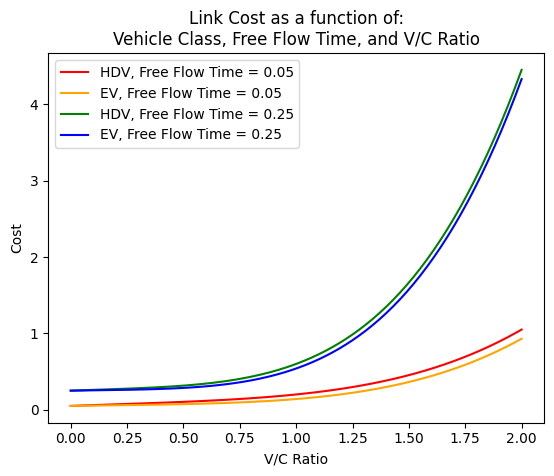

In [17]:
testlink = Link(Network(), 0, 0)
testlink.capacity = 1
range_VCRatio = [i/100 for i in range(0,201)]
TTdict = defaultdict(list)
TTkeylist = []
for fft in [fftmin, fftmax]:
    testlink.freeFlowTime = fft
    HDV, EPV = 'HDV, Free Flow Time = '+str(fft), 'EV, Free Flow Time = '+str(fft)
    TTkeylist.append([HDV, EPV])
    for VC in range_VCRatio:
        testlink.flow = VC
        TTdict[HDV].append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 1.0))
        TTdict[EPV].append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 0.4))

for key, color in zip(TTkeylist[0], ['red', 'orange']):
    plt.plot(range_VCRatio, TTdict[key], color = color, label = key)
for key, color in zip(TTkeylist[1], ['green', 'blue']):
    plt.plot(range_VCRatio, TTdict[key], color = color, label = key)
plt.title('Link Cost as a function of:\nVehicle Class, Free Flow Time, and V/C Ratio')
plt.xlabel('V/C Ratio')
plt.ylabel('Cost') 
plt.legend()
plt.show()

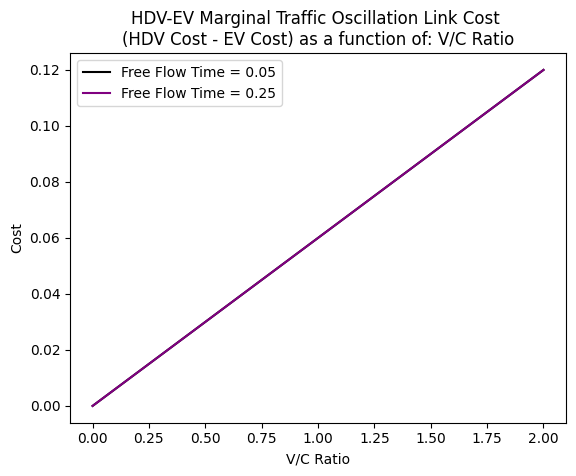

In [18]:
for key, color in zip(TTkeylist, ['black', 'purple']):
    plt.plot(range_VCRatio, np.array(TTdict[key[0]]) - np.array(TTdict[key[1]]), color = color, label = key[0][-21:])
plt.title('HDV-EV Marginal Traffic Oscillation Link Cost \n(HDV Cost - EV Cost) as a function of: V/C Ratio')
plt.xlabel('V/C Ratio')
plt.ylabel('Cost') 
plt.legend()
plt.show()

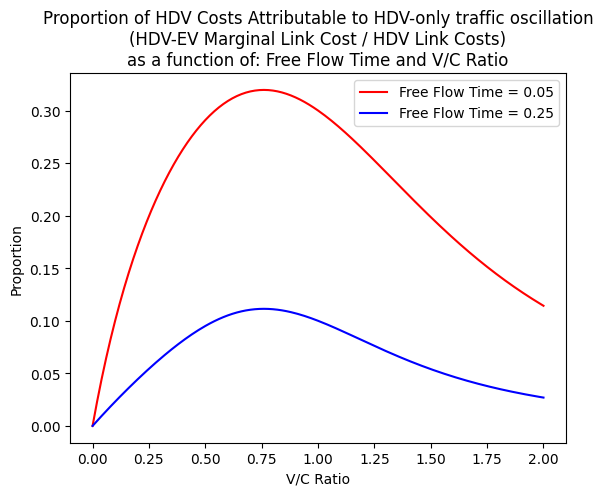

In [19]:
for key, color in zip(TTkeylist, ['red', 'blue']):
    plt.plot(range_VCRatio, (np.array(TTdict[key[0]]) - np.array(TTdict[key[1]])) / np.array(TTdict[key[0]]), 
             color = color, label = key[0][-21:])
plt.title('''Proportion of HDV Costs Attributable to HDV-only traffic oscillation
(HDV-EV Marginal Link Cost / HDV Link Costs)
as a function of: Free Flow Time and V/C Ratio''')
plt.xlabel('V/C Ratio')
plt.ylabel('Proportion') 
plt.legend()
plt.show()

# Analysis - Scenarios 1-3

_For analyzing the system performance, the primary measures of system performance we will be using are the system travel times and the V/C ratio of each link._

1. Using the travel time metrics, the system performance was plotted for both the minimum travel times in the network for each scenario.  
The drop observed in travel times from Scenario 1 to Scenario 2 is very significant. There is a minimal increase in travel times from Scenario 2 to Scenario 3. Hence, it can be seen that the performance is greatly improved with the addition of EVs to the network i.e., better than a single class HDV network. This is a result of the difference in various vehicle characteristics, such as reaction time, energy consumption, and speed limits.

2. The plotting of link costs shows that at all free flow times, the EVs will always incur a lower cost than the HDVs. This is a result of the Energy consumption reduction factor that is incorporated into the cost calculation of EVs.

3. The following is the plot of the proportion of costs attributable to the extra traffic oscillation cost of being an HDV (versus being an EV). To be precise, it shows the savings made by users on switching their mode of transport. The peak costs occur when the ratio of V/C is approximately 0.75. The graph shows that when free-flow time is 0.05 &amp; V/C is 0.75, the EVs can shave off around 30% of the additional costs incurred. This is a major gain and provides an incentive for people to switch from an HDV to an EV.


4. To understand the impact on system performance from a wider perspective, the V/C ratios of each and every link in the network have been plotted. The resulting graphs for each scenario provide a better comparison of each scenario.  
As with the metric of system travel time, the V/C ratio values across the links also show similar behavior. As soon as the network becomes a multiclass one, the performance improves across the network. The V/C ratios greatly decrease which indicates a decrease in congestion.  
Once again, as seen in the travel time comparison, the improvements from Scenario 2- Scenario 3 is minimal. Besides this, it is also interesting to note that the decrease in the V/C ratio is significant across all links except link &#39;17-19&#39;. This remains the most congested link. This is an interesting point of discussion as we believe the change in location of the charging lane to link 17-19 could help alleviate the congestion and improve performance further.

In [20]:
### Archived Code
# testlink = Link(Network(), 0, 0)
# testlink.capacity = 1
# testlink.freeFlowTime = 3 / 60
# vclist = []
# TT1, TT2 = [], []
# TT3, TT4 = [], []
# for i in range(0,201):
#     vc = i/100
#     testlink.flow = vc
#     vclist.append(vc)
#     TT1.append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 1.0))
#     TT2.append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 0.4))
# testlink.freeFlowTime = 15 / 60
# for i in range(0,201):
#     vc = i/100
#     testlink.flow = vc
#     TT3.append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 1.0))
#     TT4.append(calculateCost_OSC(testlink, lambd = 0.1, K_e = 0.4))

# plt.plot(vclist, np.array(TT1), color ='red')
# plt.plot(vclist, np.array(TT2), color ='orange')
# plt.plot(vclist, np.array(TT1) - np.array(TT2), color ='black')
# plt.plot(vclist, np.array(TT3), color ='green')
# plt.plot(vclist, np.array(TT4), color ='blue')
# plt.plot(vclist, np.array(TT3) - np.array(TT4), color ='purple')

# plt.show()

In [21]:
### Archived Code
# plt.plot(vclist, (np.array(TT1) - np.array(TT2)) / np.array(TT1), color ='black')
# plt.plot(vclist, (np.array(TT3) - np.array(TT4)) / np.array(TT3), color ='purple')
# plt.plot(vclist, (np.array(TT1) - np.array(TT2)), color ='green')
# plt.plot(vclist, (np.array(TT3) - np.array(TT4)), color ='red')


# for key, color in zip(TTkeylist, ['brown', 'red']):
#     plt.plot(range_VCRatio, np.array(TTdict[key[0]]) - np.array(TTdict[key[1]]), color = color)

## Analysis and Visualization Functions

In [22]:
# Print all link variables for a list of networks
def print_vars(networks):
    for network in networks:
        print(vars(network.link[lk]))

In [23]:
# Create a dataframe from a list of networks
def create_link_dataframe(networks):
    assert all([isinstance(globals()[net], Network) for net in networks])
    linkdata = []
    for net in networks:
        for lk, lk_obj in globals()[net].link.items():
            linkdata.append(pd.DataFrame.from_dict(vars(globals()[net].link[lk]), orient = 'index', columns = [net]))
    return pd.concat(linkdata, axis = 1).transpose().drop(columns=['network']) \
            .reset_index().rename(columns={'index':'network'})

In [24]:
# Create a dataframe of each link's V/C Ratio
def create_VC_dataframe(df):
    df['VCRatio'] = df['flow'] / df['capacity']
    df.network = df.network.apply(lambda x: x[:4])
    return df.groupby(['network','tail','head'])['VCRatio'].sum().reset_index()

In [25]:
# Draw a network. Takes a network dataframe as input.
# dict_coord must be a dictionary in the format: {NODE, (X,Y)}
# Parameters for legend scaling, legend parameter, and title
def draw_network(df_net, dict_coord, scalemin, scalemax, legend, title):
    G = nx.DiGraph()
    G.add_edges_from([(t,h,{'weight': vc}) 
                      for t,h,vc in zip(df_net['tail'], df_net['head'], df_net['weight'])])
    G.add_nodes_from([(n,{'ID':n}) for n in set([t for t in df_net['tail']] + [h for h in df_net['head']])])

    cmap = mpl.cm.plasma_r
#     scalemin, scalemax = 2, 4
    pos = dict_coord
    nx.draw_networkx_nodes(G, pos, node_color = 'grey', alpha = 0.5)
    node_labels = nx.get_node_attributes(G,'ID')
    nx.draw_networkx_labels(G, pos, labels = node_labels)
    edge_colors = list(nx.get_edge_attributes(G,'weight').values())
    edges = nx.draw_networkx_edges(G, pos, connectionstyle = 'arc3, rad = 0.1', edgelist = G.edges, width = 2,
                           edge_color = edge_colors, edge_cmap = cmap, edge_vmin=scalemin, edge_vmax=scalemax)

    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array([scalemin, scalemax])
#     ax = plt.gca()
#     plt.axis('off')
    plt.colorbar(pc, label = legend)
    plt.title(title)
    
    plt.show()

In [26]:
### Archived Code
# G = nx.DiGraph()
# G.add_edges_from([(t,h,{'VCRatio': vc, 'weight': vc / df_vc1['VCRatio'].max()}) 
#                   for t,h,vc in zip(df_vc1['tail'], df_vc1['head'], df_vc1['VCRatio'])])
# G.add_nodes_from([(n,{'ID':n}) for n in set([t for t in df_vc1['tail']] + [h for h in df_vc1['head']])])

# cmap = mpl.cm.plasma_r
# scalemin, scalemax = 2, 4
# pos = nodeloc
# nx.draw_networkx_nodes(G, pos, node_color = 'grey', alpha = 0.5)
# node_labels = nx.get_node_attributes(G,'ID')
# nx.draw_networkx_labels(G, pos, labels = node_labels)
# edge_colors = list(nx.get_edge_attributes(G,'VCRatio').values())
# edges = nx.draw_networkx_edges(G, pos, connectionstyle = 'arc3, rad = 0.1', edgelist = G.edges, width = 2,
#                        edge_color = edge_colors, edge_cmap = cmap, edge_vmin=scalemin, edge_vmax=scalemax)

# pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# pc.set_array([scalemin, scalemax])
# plt.colorbar(pc)
# ax = plt.gca()
# plt.axis('off')
# plt.show()

# Scenarios 1-3: Analysis

In [27]:
nodeloc = {1: (0, 21), 2: (15, 21), 3: (0, 18), 4: (5, 18), 5: (10, 18), 6: (15, 18), 9: (10, 15), 8: (15, 15), 
           7: (20, 15), 12: (0, 12), 11: (5, 12), 10: (10, 12), 16: (15, 12), 18: (20, 12), 17: (15, 9), 14: (5, 6), 
           15: (10, 6), 19: (15, 6), 23: (5, 3), 22: (10, 3), 13: (0, 0), 24: (5, 0), 21: (10, 0), 20: (15, 0)}

In [28]:
networklist = ['net1_HDV']
df_net = create_link_dataframe(networklist)
df_vc1 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

In [29]:
networklist = ['net2_HDV', 'net2_EPV']
df_net = create_link_dataframe(networklist)
df_vc2 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

In [30]:
networklist = ['net3_HDV', 'net3_EPV']
df_net = create_link_dataframe(networklist)
df_vc3 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

In [31]:
nodeloc3 = {91015: (8, 9)}
nodeloc3.update(nodeloc)

<ipython-input-25-1b5030c3bbda>:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc, label = legend)


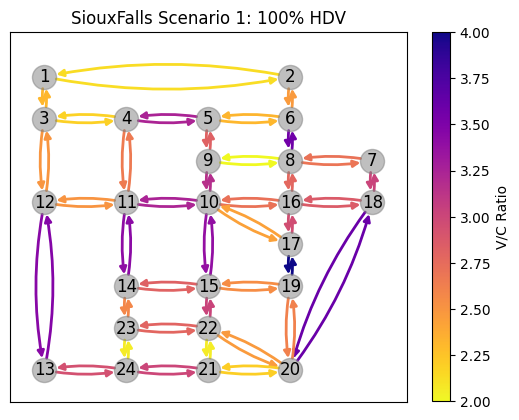

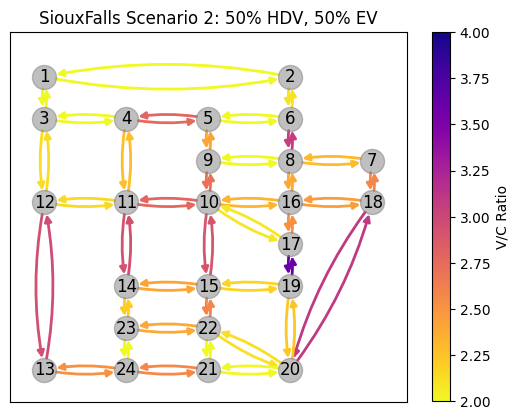

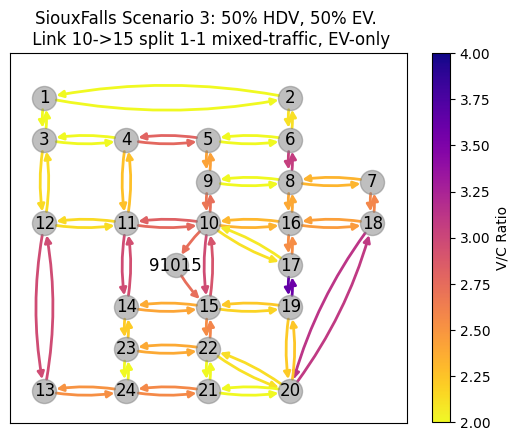

In [32]:
draw_network(df_net = df_vc1, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 1: 100% HDV')
draw_network(df_net = df_vc2, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 2: 50% HDV, 50% EV')
draw_network(df_net = df_vc3, dict_coord = nodeloc3, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 3: 50% HDV, 50% EV. \n Link 10->15 split 1-1 mixed-traffic, EV-only')

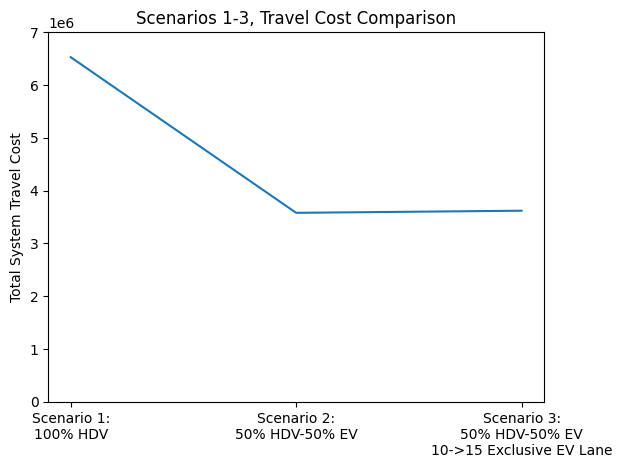

In [33]:
plt.plot(['Scenario 1:\n100% HDV', 'Scenario 2:\n50% HDV-50% EV', 'Scenario 3:\n50% HDV-50% EV\n10->15 Exclusive EV Lane'], 
         [log1.TSTC.min(), log2.TSTC.min(), log3.TSTC.min()])
plt.title('Scenarios 1-3, Travel Cost Comparison')
plt.ylabel('Total System Travel Cost') 
plt.ylim(0, 7*10**6)
plt.show()

# Further Analysis - Proposed Scenarios

For further investigation into the scenario, although we have observed that the introduction of EVs improves the network as a whole, the specific impacts of each vehicle parameter are yet to be determined. Hence two scenarios in which **penetration rate** and **reaction time** are changed are implemented. Moreover from the V/C comparison of links across all scenarios, since the congestion at link 17-19 is consistent between scenarios, a new scenario with the position of the **charging lane being changed to 17-19** was also implemented.

The results of each of these are shown below: -

1. **Scenario 4.1:**

    _Changing penetration rate - H:E = 1:3_

    The resulting graph shows that as we increased the penetration rate of EVs from 50% to 75%, the system performance has also improved from Scenario 2. The V/C ratios of these links have kept decreasing, decreasing congestion and improving travel times. This result supports our finding that the introduction of EVs into the network will only improve the system performance, and this is a result of the reduced costs. 
    

2. **Scenario 4.2:**

    _Changing reaction time – 0.5 seconds_

    The resulting graph shows that as we decreased the reaction time of EVs to0.5 seconds from the original value of 1 second, the network performance greatly improved from Scenario 2. This result provides support to the expected fact that as the vehicle parameters of EVs improve, the performance of the network should also rise. 
    

3. **Scenario 4.3:**

    _Conversion of link 17-19 – One lane is converted to a charging lane_
    
    This new implementation was done to investigate the effects of changing the position of the charging lane to the most congested link (link 17-19). The resulting graph offers a similar state of the network as was in Scenario 3. The congestion is still at a maximum in that link. In effect, the addition of the link only increases travel time on the mixed link, but has lower time on the EV only link. 
    

# Scenario 4.1: Analysis 

In [34]:
networklist = ['net4_1_HDV', 'net4_1_EPV']
df_net = create_link_dataframe(networklist)
df_vc4_1 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

<ipython-input-25-1b5030c3bbda>:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc, label = legend)


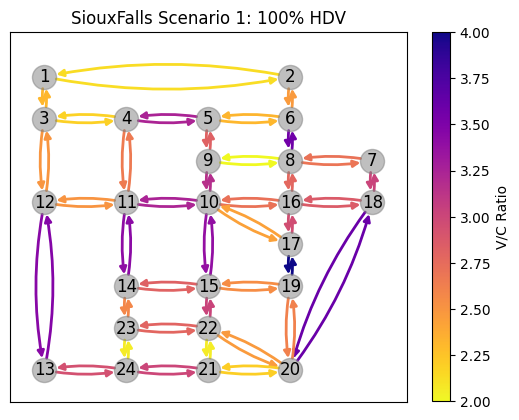

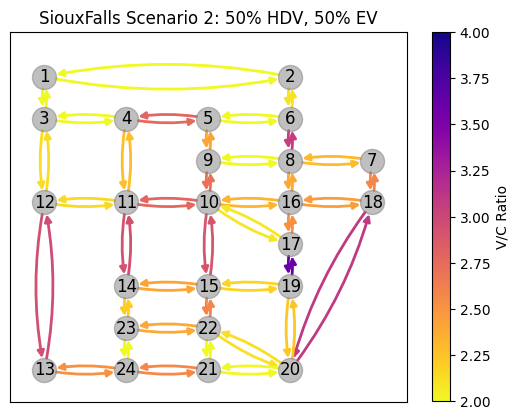

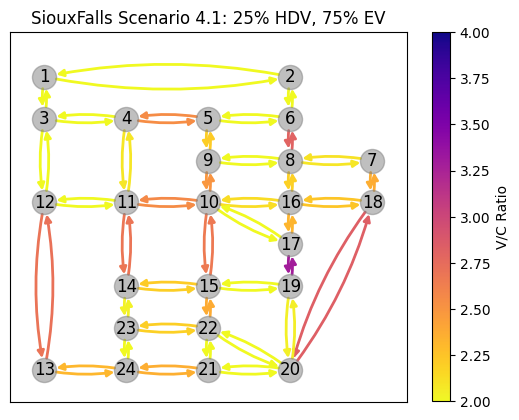

In [35]:
draw_network(df_net = df_vc1, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 1: 100% HDV')
draw_network(df_net = df_vc2, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 2: 50% HDV, 50% EV')
draw_network(df_net = df_vc4_1, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 4.1: 25% HDV, 75% EV')

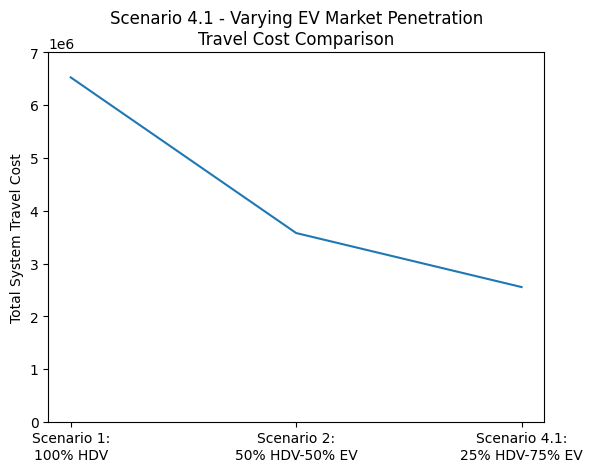

In [36]:
plt.plot(['Scenario 1:\n100% HDV', 'Scenario 2:\n50% HDV-50% EV', 'Scenario 4.1:\n25% HDV-75% EV'], 
         [log1.TSTC.min(), log2.TSTC.min(), log4_1.TSTC.min()])
plt.title('Scenario 4.1 - Varying EV Market Penetration\nTravel Cost Comparison')
plt.ylabel('Total System Travel Cost') 
plt.ylim(0, 7*10**6)
plt.show()

# Scenario 4.2: Analysis 

In [38]:
networklist = ['net4_2_HDV', 'net4_2_EPV']
df_net = create_link_dataframe(networklist)
df_vc4_2 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

<ipython-input-25-1b5030c3bbda>:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc, label = legend)


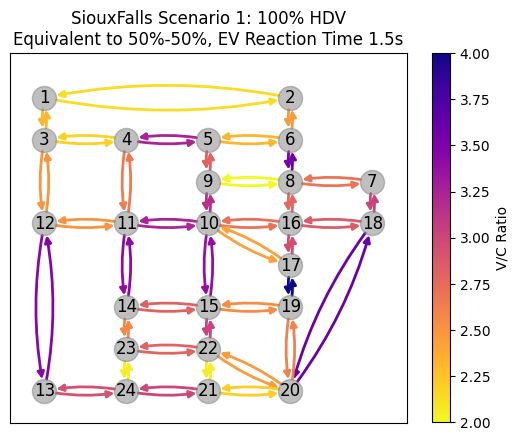

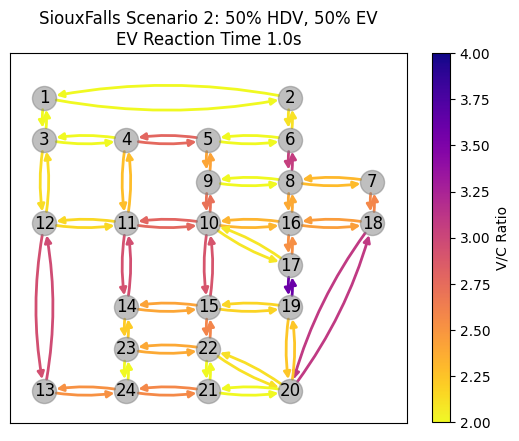

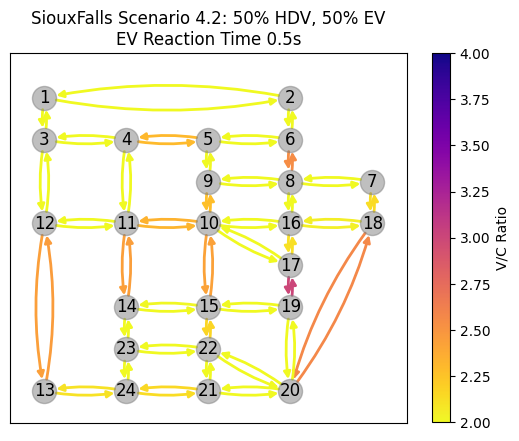

In [39]:
draw_network(df_net = df_vc1, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 1: 100% HDV\nEquivalent to 50%-50%, EV Reaction Time 1.5s')
draw_network(df_net = df_vc2, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 2: 50% HDV, 50% EV\nEV Reaction Time 1.0s')
draw_network(df_net = df_vc4_2, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 4.2: 50% HDV, 50% EV\nEV Reaction Time 0.5s')

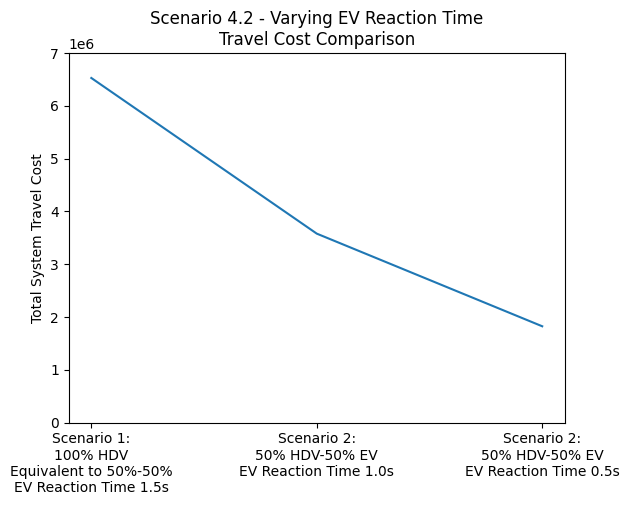

In [40]:
plt.plot(['Scenario 1:\n100% HDV\nEquivalent to 50%-50%\nEV Reaction Time 1.5s', 
          'Scenario 2:\n50% HDV-50% EV\nEV Reaction Time 1.0s', 
          'Scenario 2:\n50% HDV-50% EV\nEV Reaction Time 0.5s'], 
         [log1.TSTC.min(), log2.TSTC.min(), log4_2.TSTC.min()])
plt.title('Scenario 4.2 - Varying EV Reaction Time\nTravel Cost Comparison')
plt.ylabel('Total System Travel Cost') 
plt.ylim(0, 7*10**6)
plt.show()

# Scenario 4.3: Analysis 

In [41]:
networklist = ['net4_3_HDV', 'net4_3_EPV']
df_net = create_link_dataframe(networklist)
df_vc4_3 = create_VC_dataframe(df_net).rename(columns={'VCRatio':'weight'})

In [42]:
nodeloc4_3 = {91719: (12, 7.5)}
nodeloc4_3.update(nodeloc)

<ipython-input-25-1b5030c3bbda>:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc, label = legend)


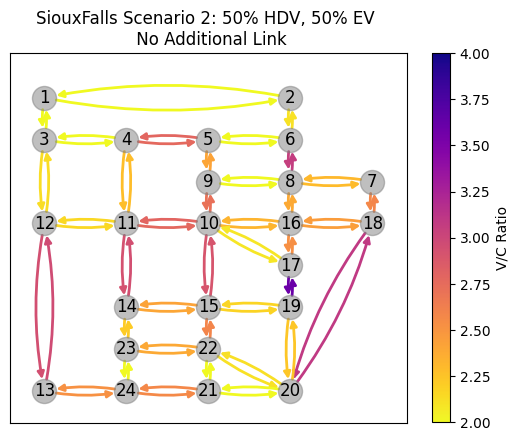

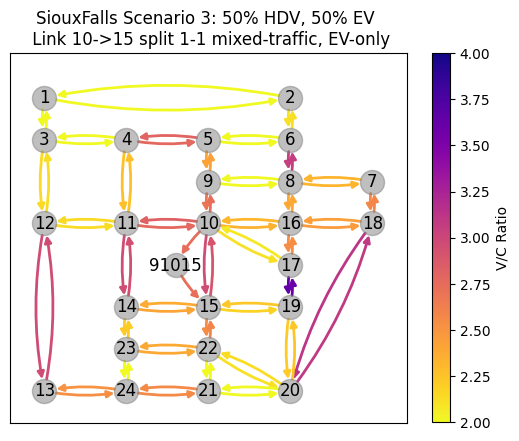

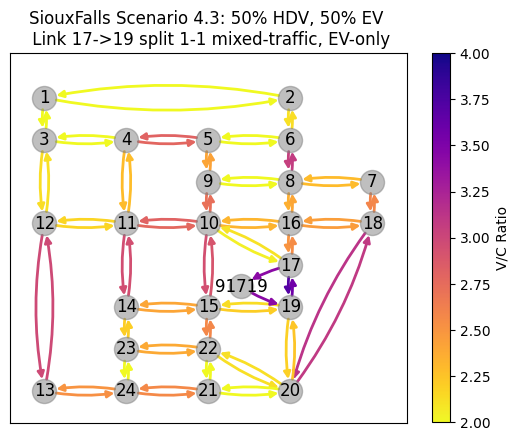

In [43]:
draw_network(df_net = df_vc2, dict_coord = nodeloc, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 2: 50% HDV, 50% EV \n No Additional Link')
draw_network(df_net = df_vc3, dict_coord = nodeloc3, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 3: 50% HDV, 50% EV \n Link 10->15 split 1-1 mixed-traffic, EV-only')
draw_network(df_net = df_vc4_3, dict_coord = nodeloc4_3, scalemin = 2, scalemax = 4, legend = "V/C Ratio",
             title = 'SiouxFalls Scenario 4.3: 50% HDV, 50% EV \n Link 17->19 split 1-1 mixed-traffic, EV-only')

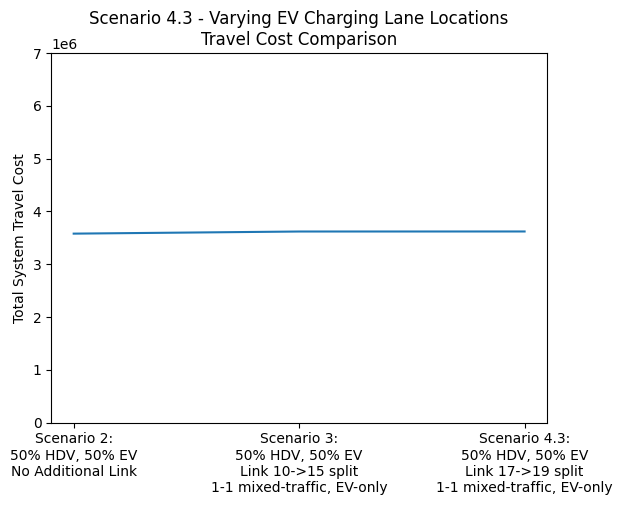

In [44]:
plt.plot(['Scenario 2:\n50% HDV, 50% EV\nNo Additional Link', 
          'Scenario 3:\n50% HDV, 50% EV\nLink 10->15 split\n1-1 mixed-traffic, EV-only', 
          'Scenario 4.3:\n50% HDV, 50% EV\nLink 17->19 split\n1-1 mixed-traffic, EV-only'], 
         [log2.TSTC.min(), log3.TSTC.min(), log4_3.TSTC.min()])
plt.title('Scenario 4.3 - Varying EV Charging Lane Locations\nTravel Cost Comparison')
plt.ylabel('Total System Travel Cost') 
plt.ylim(0, 7*10**6)
plt.show()

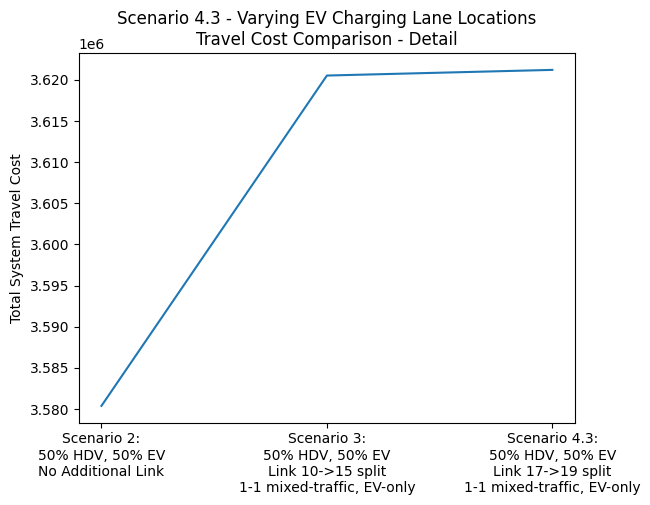

In [45]:
plt.plot(['Scenario 2:\n50% HDV, 50% EV\nNo Additional Link', 
          'Scenario 3:\n50% HDV, 50% EV\nLink 10->15 split\n1-1 mixed-traffic, EV-only', 
          'Scenario 4.3:\n50% HDV, 50% EV\nLink 17->19 split\n1-1 mixed-traffic, EV-only'], 
         [log2.TSTC.min(), log3.TSTC.min(), log4_3.TSTC.min()])
plt.title('Scenario 4.3 - Varying EV Charging Lane Locations\nTravel Cost Comparison - Detail')
plt.ylabel('Total System Travel Cost') 
# plt.ylim(0, 7*10**6)
plt.show()

# **Q3)** 



--------------------------